In [1]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

In [2]:
class SMnet(nn.Module):
    def __init__(self):
        super(SMnet, self).__init__()
        self.linear_start1 = nn.Linear(20,128)#20,128
        self.linear_start2 = nn.Linear(128,256)#128,256
        #self.linear_start1.cuda()
        #self.linear_start2.cuda()
        self.lstm = nn.LSTM(
            input_size=256, 
            hidden_size=512, 
            num_layers=3,
            batch_first=True)#256,512,3
        
       # self.lstm.cuda()
        self.linear1 = nn.Linear(512, 256)#512,256
        self.linear2 = nn.Linear(256, 3)#256,3
        #self.linear1.cuda()
        #self.linear2.cuda()
        
    def forward(self, robot_sensors):
        ls_out1 = self.linear_start1(robot_sensors)
        ls_out2 = self.linear_start2(ls_out1)
        lstm_out, (h_n, h_c) = self.lstm(ls_out2)
        l_out1 = self.linear1(lstm_out)
        l_out2 = self.linear2(l_out1)

        return l_out2
        

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

data_x= pd.read_csv('joints_tobar.txt',delimiter=" ",header=None)
data_y= pd.read_csv('ground_truth.txt',delimiter=" ",header=None)
feat=data_x.as_matrix()
gtruth=data_y.as_matrix()

print('{0:2d} datos de entrada con tamaño {1:2d}'.format(len(feat),len(feat[0])))
print('{0:2d} datos de salida con tamaño {1:2d}'.format(len(gtruth),len(gtruth[0])))
y=[]
x=[]
time=[]
#print(ground_t)
#Extraer x,y,z
for i in range(0,len(feat)):
    xi=[]
    for j in range(1,len(feat[0])):
        xi.append(feat[i][j])
    x.append(xi)
    time.append(feat[i][0])
    #if i%10000==0:
        #print(xi)
        
for i in range(0,len(gtruth)):
    pos=[]
    pos.append(gtruth[i][1])
    pos.append(gtruth[i][2])
    pos.append(gtruth[i][3])
    y.append(pos)
    #if i%10000==0:
        #print(pos)
        
print('{0:2d} datos de entrada con tamaño {1:2d}'.format(len(x),len(x[0])))
print('{0:2d} datos de salida con tamaño {1:2d}'.format(len(y),len(y[0])))

46874 datos de entrada con tamaño 21
46874 datos de salida con tamaño  8
46874 datos de entrada con tamaño 20
46874 datos de salida con tamaño  3


tamaño características de entrenamiento: 10000
tamaño características de validacion: 11874
--------------------------------------------------------------------
tamaño groundtruth de entrenamiento: 10000
tamaño groundtruth de validacion: 11874


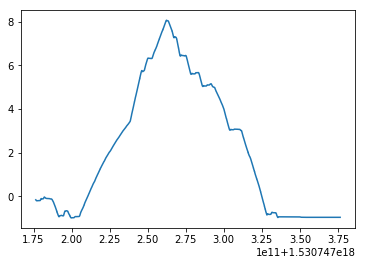

In [4]:
x_train= x[:10000]
y_train= y[:10000]
t_train=time[:10000]



y_plot=[]
for i in range(0,len(y_train)):
    y_plot.append(y_train[i][0])

plt.plot(t_train,y_plot)
    
x_val = x[35000:]
y_val = y[35000:]
t_val=time[35000:]
print('tamaño características de entrenamiento: {0:2d}'.format(len(x_train)))
print('tamaño características de validacion: {0:2d}'.format(len(y_val)))
print('--------------------------------------------------------------------')
print('tamaño groundtruth de entrenamiento: {0:2d}'.format(len(x_train)))
print('tamaño groundtruth de validacion: {0:2d}'.format(len(y_val)))

In [5]:
import sklearn as skl
std_scale=skl.preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_val = std_scale.transform(x_val)
std_scale=skl.preprocessing.StandardScaler().fit(y)
y_train = std_scale.transform(y_train)
y_val = std_scale.transform(y_val)
#np.interp(a, (a.min(), a.max()), (-1, +1))

In [6]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
input= torch.from_numpy(np.array(x_train))
target = torch.from_numpy(np.array(y_train))
#target = target.unsqueeze(0)
test_input = torch.from_numpy(np.array(x_val))
test_target = torch.from_numpy(np.array(y_val))
# build the model
sm = SMnet()
sm.double()
criterion = nn.L1Loss(size_average=False)
# create your optimizer
optimizer = optim.SGD(sm.parameters(), lr=0.001, momentum=0.9)

C:\Users\Giopa\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [7]:
# in your training loop:
batch_size=5
for i in range(500):
    optimizer.zero_grad()   # zero the gradient buffers
    batch = input[i:i+batch_size,:]
    batch = batch.unsqueeze(0)
    #print(batch.size())
    batch_target = target[i:i+batch_size,:]
    batch_target = batch_target.unsqueeze(0)
    output = sm(batch)
    loss = criterion(output, batch_target)
    print("loss: {}   ({}%)".format(loss,(i/5)))
    loss.backward()
    optimizer.step() # Does the update

loss: 12.975443065680226   (0.0%)
loss: 12.831225181708403   (0.2%)
loss: 12.56931911271943   (0.4%)
loss: 12.197240539990636   (0.6%)
loss: 11.733225542410006   (0.8%)
loss: 11.17756894195345   (1.0%)
loss: 10.542113062731271   (1.2%)
loss: 9.854395857740496   (1.4%)
loss: 9.098239248500034   (1.6%)
loss: 8.302240822079652   (1.8%)
loss: 7.994049717206755   (2.0%)
loss: 8.070226326535924   (2.2%)
loss: 7.995312889777962   (2.4%)
loss: 7.806498743615661   (2.6%)
loss: 7.488881944725564   (2.8%)
loss: 7.072383548123275   (3.0%)
loss: 6.555645114534554   (3.2%)
loss: 5.974508126129751   (3.4%)
loss: 5.3111044375832615   (3.6%)
loss: 4.57989918487834   (3.8%)
loss: 4.303190791986788   (4.0%)
loss: 4.146227784173181   (4.2%)
loss: 3.8321485554063397   (4.4%)
loss: 3.383789426041331   (4.6%)
loss: 2.8042310344097325   (4.8%)
loss: 2.1082115449979026   (5.0%)
loss: 1.2840602110700325   (5.2%)
loss: 0.7830534413734784   (5.4%)
loss: 0.6963845093463751   (5.6%)
loss: 1.1665159388172597   (5.8%

loss: 0.2346119131636145   (46.8%)
loss: 0.253684218858135   (47.0%)
loss: 0.17243661870043647   (47.2%)
loss: 0.2620209320582154   (47.4%)
loss: 0.3709237672279952   (47.6%)
loss: 0.48853163595499005   (47.8%)
loss: 0.4812611472858435   (48.0%)
loss: 0.3035379254567339   (48.2%)
loss: 0.33301663341398124   (48.4%)
loss: 0.31180446819689056   (48.6%)
loss: 0.4612910385294766   (48.8%)
loss: 0.4503296730471059   (49.0%)
loss: 0.6183549076501784   (49.2%)
loss: 0.6453714247819237   (49.4%)
loss: 0.4849766677709111   (49.6%)
loss: 0.17834720932563342   (49.8%)
loss: 0.2511675317166655   (50.0%)
loss: 0.44692043081600275   (50.2%)
loss: 0.44612154658333486   (50.4%)
loss: 0.31716822216683205   (50.6%)
loss: 0.1556048434943358   (50.8%)
loss: 0.3010057887909905   (51.0%)
loss: 0.4347112857740343   (51.2%)
loss: 0.6001490362825106   (51.4%)
loss: 0.6826728919060402   (51.6%)
loss: 0.6658138992465016   (51.8%)
loss: 0.7728431369731655   (52.0%)
loss: 0.7525376867298011   (52.2%)
loss: 0.71786

loss: 0.0835339239430273   (93.0%)
loss: 0.057598940545127514   (93.2%)
loss: 0.049664745896354306   (93.4%)
loss: 0.09059998493966415   (93.6%)
loss: 0.08708898356734004   (93.8%)
loss: 0.06452013149999922   (94.0%)
loss: 0.09979911360677154   (94.2%)
loss: 0.12506826912438515   (94.4%)
loss: 0.1125079157669458   (94.6%)
loss: 0.046229852036256014   (94.8%)
loss: 0.12642469111361643   (95.0%)
loss: 0.1264986398809978   (95.2%)
loss: 0.1978060989511364   (95.4%)
loss: 0.1614307754645323   (95.6%)
loss: 0.027950241462936315   (95.8%)
loss: 0.13904218422477138   (96.0%)
loss: 0.16220058331377238   (96.2%)
loss: 0.13517083500013716   (96.4%)
loss: 0.07615884022933936   (96.6%)
loss: 0.0840949617748459   (96.8%)
loss: 0.07053460735227773   (97.0%)
loss: 0.0786453638921994   (97.2%)
loss: 0.07462940040370941   (97.4%)
loss: 0.0669939482609265   (97.6%)
loss: 0.049409763996943856   (97.8%)
loss: 0.03025664981051976   (98.0%)
loss: 0.06411793570213284   (98.2%)
loss: 0.034349342421453655   (9

In [8]:
sm.eval()

SMnet(
  (linear_start1): Linear(in_features=20, out_features=128, bias=True)
  (linear_start2): Linear(in_features=128, out_features=256, bias=True)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
)

In [9]:
print(input.size())

torch.Size([10000, 20])


In [10]:
Z = sm(input.unsqueeze(0))

In [11]:
Z=Z.view(-1,3)
print(Z)

tensor([[ 0.2869,  0.1519, -1.6536],
        [ 0.2869,  0.1468, -1.6536],
        [ 0.2870,  0.1435, -1.6526],
        ...,
        [ 0.2869,  0.1394, -1.6450],
        [ 0.2869,  0.1394, -1.6450],
        [ 0.2868,  0.1394, -1.6449]],
       dtype=torch.float64, grad_fn=<ViewBackward>)


In [13]:
    x_pred,x_true=[],[]
    y_pred,y_true=[],[]
    z_pred,z_true=[],[]
    for k in range(0,len(y_train)):
        x_pred.append(Z[k][0].item())
        x_true.append(y_train[k][0].item())
        y_pred.append(Z[k][1])
        y_true.append(y_train[k][1])
        z_pred.append(Z[k][2])
        z_true.append(y_train[k][2])

x RMSE: 1.7491601302800344
y RMSE: 1.8883678107596984
z RMSE: 1.3307705969638657
-----------------------------------
Partida ajustada manual
x RMSE: 1.4457746297566263
y RMSE: 2.5188457061080936
z RMSE: 0.582704093552279


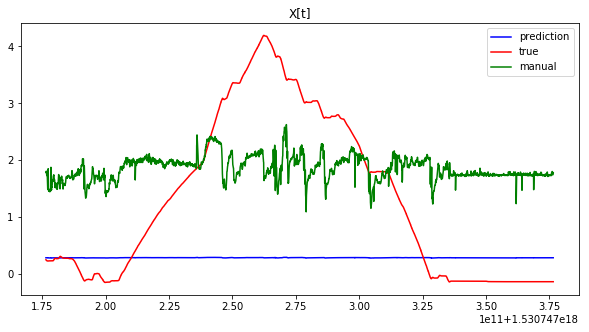

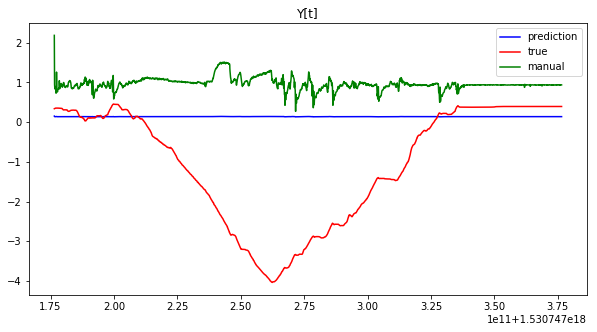

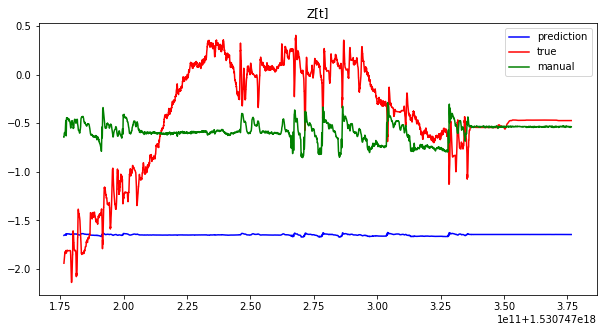

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(x_true, x_pred))
print('x RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

rms = sqrt(mean_squared_error(y_true, y_pred))
print('y RMSE: {}'.format(rms)) # Sin normalizar: 0.6174| Con normalizar: 0.6184

rms = sqrt(mean_squared_error(z_true, z_pred))
print('z RMSE: {}'.format(rms)) # Sin normalizar: 0.1204| Con normalizar: 0.1091

print('-----------------------------------')
print('Partida ajustada manual')

x_p,y_p,z_p=[],[],[]

for i in range(0,len(x_pred)):
    x_p.append(x_pred[i]*100-26.9)
    y_p.append(y_pred[i]*100-13.0)
    z_p.append(z_pred[i]*12+19.2)

rms = sqrt(mean_squared_error(x_true, x_p))
print('x RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

rms = sqrt(mean_squared_error(y_true, y_p))
print('y RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

rms = sqrt(mean_squared_error(z_true, z_p))
print('z RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322



t=t_train

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(t,x_pred,'b')
plt.plot(t,x_true,'r')
plt.plot(t,x_p,'g')
plt.title('X[t]')
plt.legend(['prediction','true','manual'])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(t,y_pred,'b')
plt.plot(t,y_true,'r')
plt.plot(t,y_p,'g')
plt.title('Y[t]')
plt.legend(['prediction','true','manual'])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(t,z_pred,'b')
plt.plot(t,z_true,'r')
plt.plot(t,z_p,'g')
plt.title('Z[t]')
plt.legend(['prediction','true','manual'])
plt.show()